# **Stack Overflow: Tag Prediction**



**Objective**

Suggest the tags based on the content that was there in the question posted on Stackoverflow.

In [0]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from datetime import datetime

# Exploratory Data Analysis

## Data Loading and Cleaning

In [0]:
data = pd.read_csv("/content/drive/My Drive/AI projects/Stack overflow Tag Predictor/Train.csv")
data.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6034195 entries, 0 to 6034194
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Title   object
 2   Body    object
 3   Tags    object
dtypes: int64(1), object(3)
memory usage: 184.1+ MB


In [0]:
data.drop('Id', axis= 1, inplace= True)

In [0]:
data.dropna(axis=0, inplace= True)

In [0]:
data.isnull().sum()

Title    0
Body     0
Tags     0
dtype: int64

In [0]:
print("number of duplicate questions :", data.duplicated().sum())

number of duplicate questions : 1827880


In [0]:
df = data.drop_duplicates()

In [0]:
df.shape

(4206307, 3)

In [0]:
start = datetime.now()
df["tag_count"] = df["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df.head()

Time taken to run this cell : 0:00:02.373143


,Title,Body,Tags,tag_count
0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
4,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3


In [0]:
# distribution of number of tags per question
df.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568290
5     505158
Name: tag_count, dtype: int64

In [0]:
df.to_csv("/content/drive/My Drive/AI projects/Stack overflow Tag Predictor/data.csv", columns= ['Title', 'Body', 'Tags'], index= False)

# Analysis of Tags

In [3]:
df = pd.read_csv("/content/drive/My Drive/AI projects/Stack overflow Tag Predictor/data.csv")
df.head()

,Title,Body,Tags
0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


## Total number of unique tags

In [0]:
vectorizer = CountVectorizer(tokenizer= lambda x: x.split())
tag_data = vectorizer.fit_transform(df['Tags'])

In [0]:
print("Number of data points: ", tag_data.shape[0])
print("Number of unique tags: ", tag_data.shape[1])

Number of data points:  4206307
Number of unique tags:  42048


In [0]:
# get vocabulary
tags = vectorizer.get_feature_names()
print("Some tags: ", tags[:10])

Some tags:  ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


## Number of times a tag appeared

In [0]:
# store the ducument term matrix in a dictionary
freqs = tag_data.sum(axis= 0).A1
result = dict(zip(tags, freqs))

In [0]:
tag_df = pd.DataFrame.from_dict(result, orient= 'index').reset_index()
tag_df.columns= ['Tags', 'Counts']

In [0]:
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [0]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending= False)
tag_counts = tag_df_sorted['Counts'].values

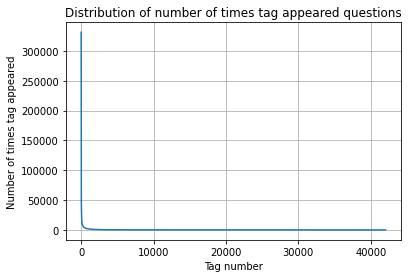

In [0]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

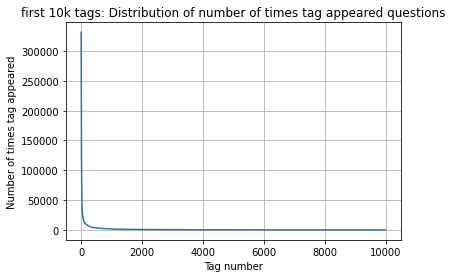

In [0]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
#print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

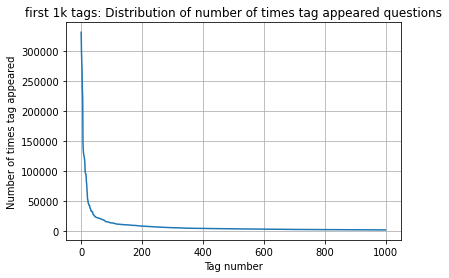

In [0]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
#print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

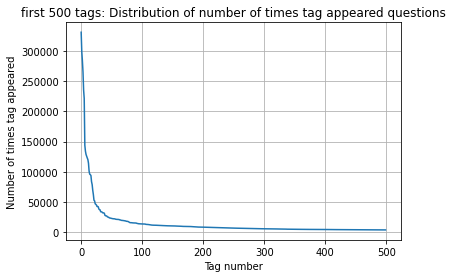

In [0]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
#print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

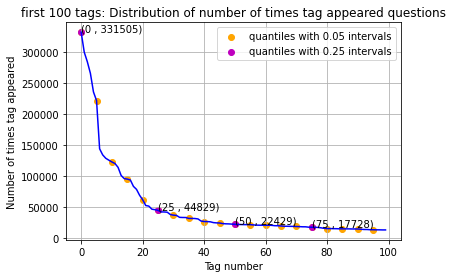

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [0]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [0]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts > 10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


**Observations**:

* There are total 153 tags which are used more than 10000 times.
* 14 tags are used more than 100000 times.
* Most frequent tag (i.e. c#) is used 331505 times.
* Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

### Tags Per Question

In [0]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_data.sum(axis=1).tolist()
#Converting list of lists into single list,
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206307 datapoints.
[5, 1, 3, 3, 3]


In [0]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899443


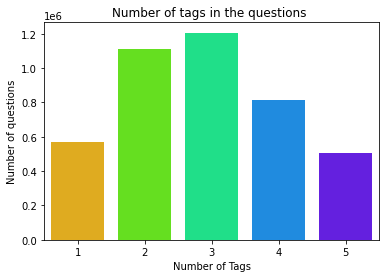

In [0]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

**Observations**:

* Maximum number of tags per question: 5
* Minimum number of tags per question: 1
* Avg. number of tags per question: 2.899
* Most of the questions are having 2 or 3 tags

### Most Frequent Tags 

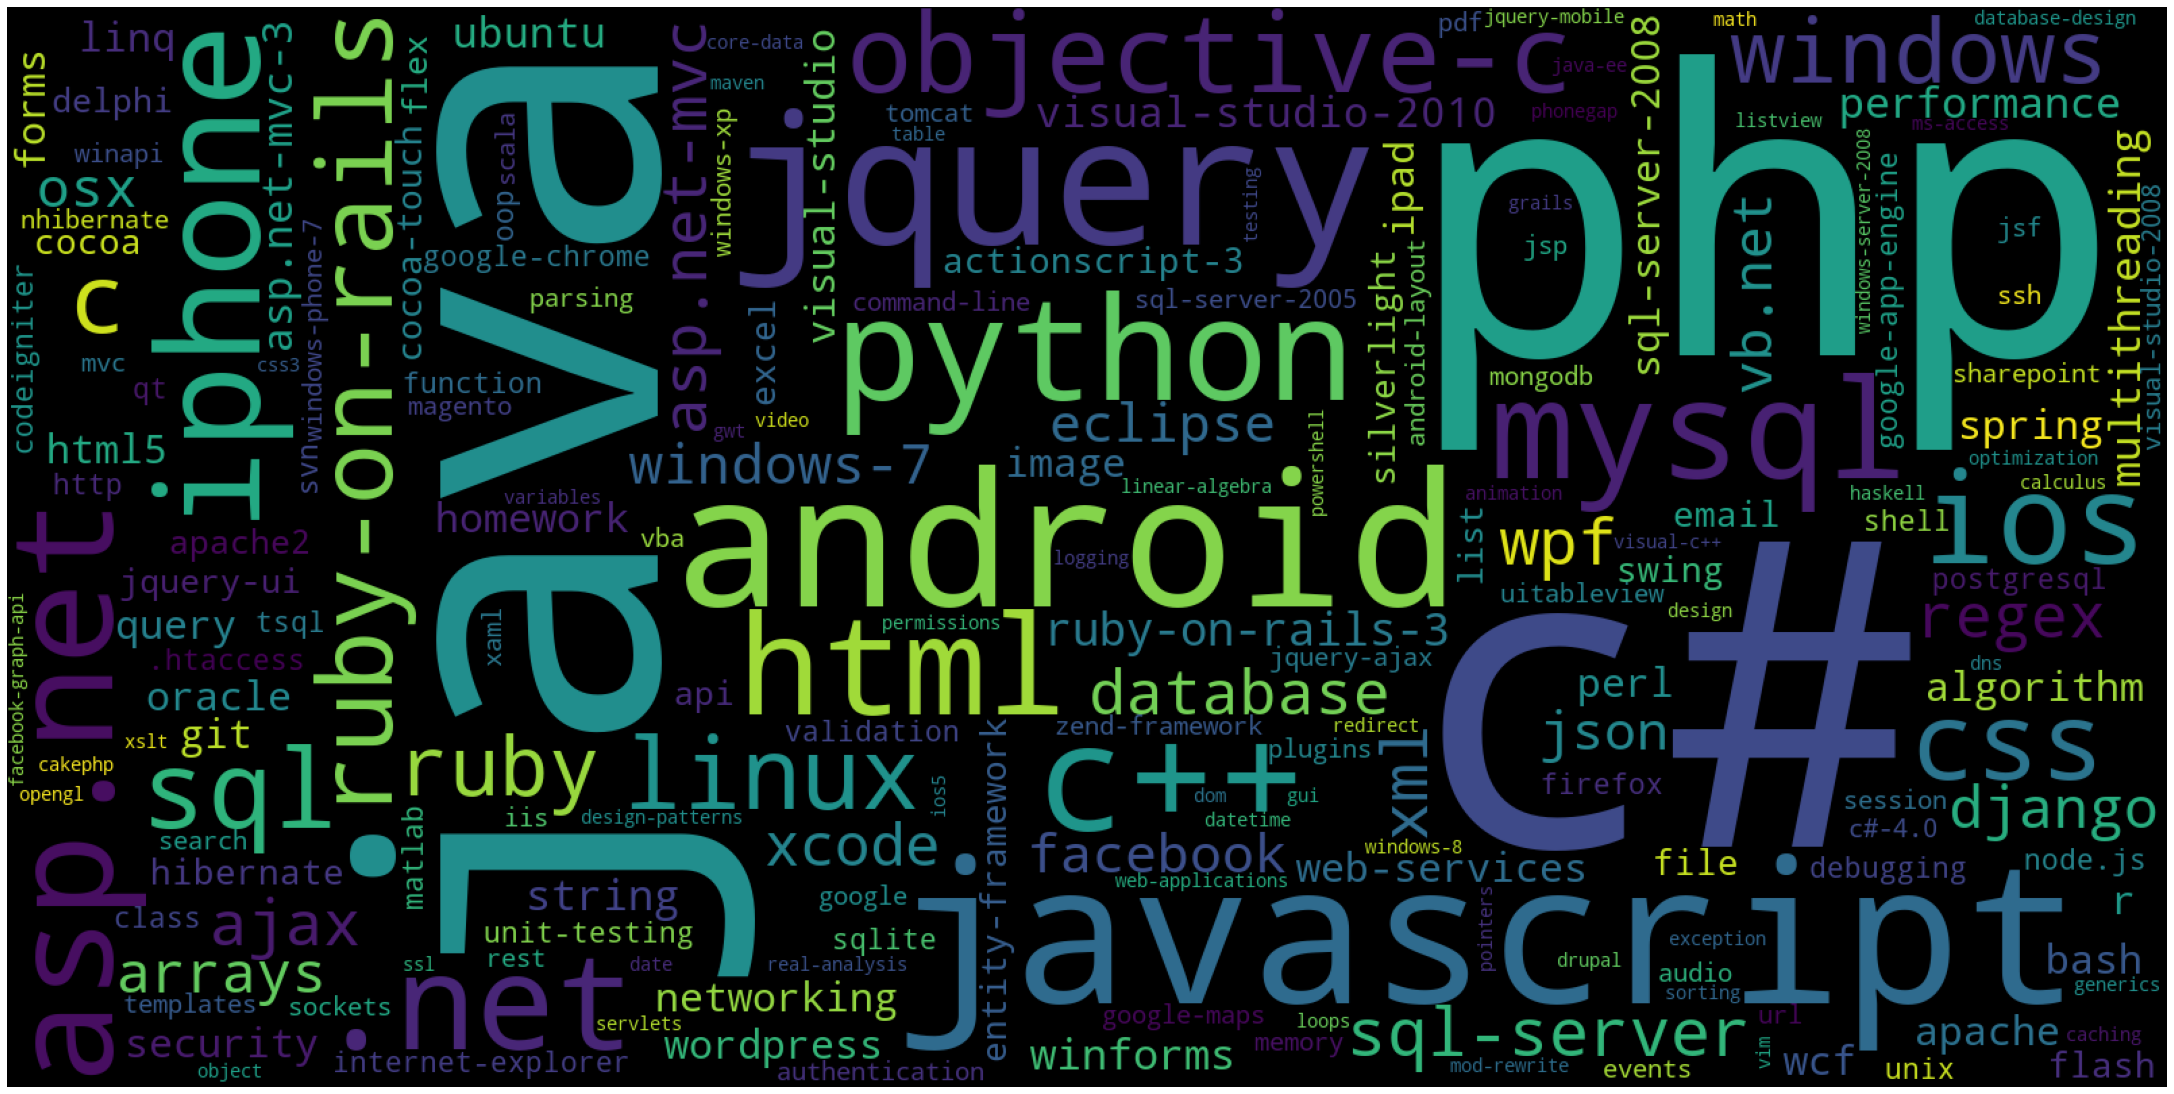

Time taken to run this cell : 0:00:04.886677


In [0]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

**Observations**:
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

### The top 20 tags

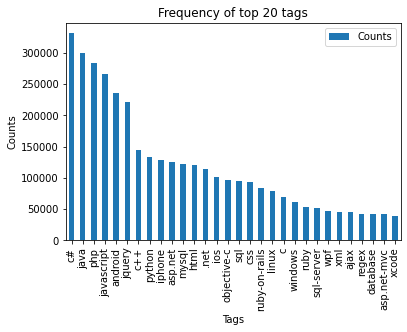

In [0]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

**Observations**:

* Majority of the most frequent tags are programming language.
* C# is the top most frequent programming language.
* Android, IOS, Linux and windows are among the top most frequent operating systems.

#  Cleaning and preprocessing of Questions

### Preprocessing

* Separate out code-snippets from Body
* Remove Spcial characters from Question title and description (not in code)
* Remove stop words (Except 'C')
Remove HTML Tags
* Convert all the characters into small letters
* Use SnowballStemmer to stem the words

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [0]:
df_sample = df.sample(n = 1000000) 

In [0]:
df_sample.shape

(1000000, 3)

In [0]:

start = datetime.now()
preprocessed_data_list=[]
# reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for index, row in df_sample.iterrows():

    is_code = 0

    title, question, tags = row["Title"], row["Body"], row["Tags"]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    preprocessed_data_list.append(tup)
    
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
number of questions completed= 1000000
Avg. length of questions(Title+Body) before processing: 1171
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 57
Time taken to run this cell : 0:23:38.757195


In [0]:
df_preprocessed = pd.DataFrame(preprocessed_data_list, columns =['Question', 'Code' ,'Tags', 'Words_pre' , 'Words_post' ,'is_code']) 

In [0]:
df_preprocessed.head()

,Question,Code,Tags,Words_pre,Words_post,is_code
0,clone subdirectori exist svn repositori common...,['http://example.com/svn/trunk/common/module_1...,git git-svn,1554,562,1
1,xcode io build succeed run hang simul debug me...,[],ios-simulator osx-mountain-lion ios5.1 xcode4.4,3324,1442,0
2,open pdf window command line search string con...,[],windows pdf search command-line-arguments,730,383,0
3,window client detect new domain control login ...,[],windows-server-2008 domain-controller,469,251,0
4,falloc implement linux ask linux ext filesyste...,['fallocate'],linux filesystems,279,141,1


In [0]:
df_preprocessed.to_csv("/content/drive/My Drive/AI projects/Stack overflow Tag Predictor/df_preprocessed.csv", index= False)

In [0]:
preprocessed_data = pd.read_csv("/content/drive/My Drive/AI projects/Stack overflow Tag Predictor/df_preprocessed.csv", usecols= ['Question', 'Tags'])

In [0]:
preprocessed_data = preprocessed_data.sample(n = 100000)

In [19]:
preprocessed_data.shape

(100000, 2)

# Machine Learning Models

## Converting tags for multilabel problems

In [0]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['Tags'])

We will sample the number of tags instead considering all of them (due to limitation of computing power)

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn = multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [0]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

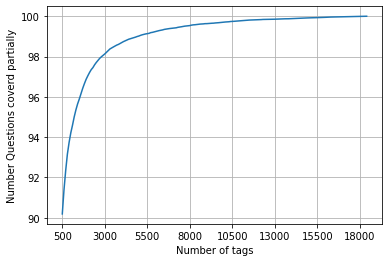

with  5500 tags we are covering  99.136 % of questions


In [23]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500  +np.array(range(-50,450,50)) * 50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [24]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 864 out of  100000


In [25]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 18456
number of tags taken : 5500 ( 29.800606848721284 %)


We consider top 29% tags which covers 99% of the questions

## Split the data into test and train (80:20)

In [0]:
from sklearn.model_selection import  train_test_split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, multilabel_yx, test_size = 0.2,random_state = 42)

In [27]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 5500)
Number of data points in test data : (20000, 5500)


## Featurizing data

In [28]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['Question'])
x_test_multilabel = vectorizer.transform(x_test['Question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:55.373955


In [29]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 90162) Y : (80000, 5500)
Dimensions of test data X: (20000, 90162) Y: (20000, 5500)


## Applying Logistic Regression with OneVsRest Classifier

In [30]:
# this will be taking so much time try not to run it, download the lr_with_equal_weight.pkl file and use to predict
# This takes about 6-7 hours to run.
start = datetime.now()

classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:19:42.375892


In [31]:
print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
#print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

accuracy : 0.07775
macro f1 score : 0.0779907099396199
micro f1 scoore : 0.371139371917986
hamming loss : 0.0004185181818181818


## Modeling with less data points (0.1M data points) and more weight to title and 500 tags only.

In [0]:
df_sample = df.sample(n = 100000) 

In [33]:
df_sample.shape

(100000, 3)

In [37]:
start = datetime.now()
preprocessed_data_list=[]
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for index, row in df_sample.iterrows():

    is_code = 0

    title, question, tags = row["Title"], row["Body"], row["Tags"]
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words = word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    preprocessed_data_list.append(tup)
    if (questions_proccesed % 100000 == 0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
Avg. length of questions(Title+Body) before processing: 1176
Avg. length of questions(Title+Body) after processing: 408
Percent of questions containing code: 57
Time taken to run this cell : 0:03:18.668393


In [0]:
df_prep_more_wt = pd.DataFrame(preprocessed_data_list, columns =['Question', 'Code' ,'Tags', 'Words_pre' , 'Words_post' ,'is_code']) 

In [39]:
df_prep_more_wt.head()

,Question,Code,Tags,Words_pre,Words_post,is_code
0,tastypi resourc includ set item tastypi resour...,['class First(models.Model):\n name = mod...,django tastypie,616,269,1
1,ef code first parent-child insert ident column...,['class Parent\n{\n int ParentId (identity ...,entity-framework code-first ef-code-first,700,299,1
2,abl send mail group email id abl send mail gro...,['MailMessage mail = new MailMessage();\nmail....,c# email smtp,1274,340,1
3,python mysqldb instal problem python mysqldb i...,"[""_mysql.c:2331: error: â_mysql_ConnectionObje...",python,1021,195,1
4,jqueri filter function .has jqueri filter func...,"['href', '.pdf', '$(\'a[href$="".pdf""]\').filte...",jquery jquery-selectors,810,332,1


In [0]:
df_prep_more_wt.to_csv("/content/drive/My Drive/AI projects/Stack overflow Tag Predictor/df_preprocessed_more_wt.csv", index= False)

In [0]:
preprocessed_data = df_prep_more_wt[['Question', 'Tags']]

In [42]:
preprocessed_data.head()

,Question,Tags
0,tastypi resourc includ set item tastypi resour...,django tastypie
1,ef code first parent-child insert ident column...,entity-framework code-first ef-code-first
2,abl send mail group email id abl send mail gro...,c# email smtp
3,python mysqldb instal problem python mysqldb i...,python
4,jqueri filter function .has jqueri filter func...,jquery jquery-selectors


In [43]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 100000
number of dimensions : 2


Converting string Tags to multilable output variables

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['Tags'])

Selecting 500 Tags

In [0]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

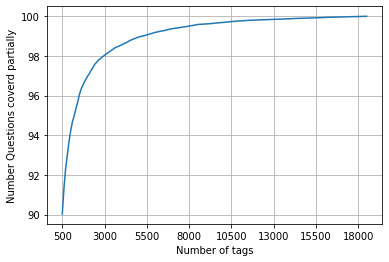

with  5500 tags we are covering  99.059 % of questions
with  500 tags we are covering  90.035 % of questions


In [46]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [47]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 9965 out of  100000


In [0]:
from sklearn.model_selection import  train_test_split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, multilabel_yx, test_size = 0.2,random_state = 42)

In [49]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 500)
Number of data points in test data : (20000, 500)


### Featurizing data with TfIdf vectorizer

In [51]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['Question'])
x_test_multilabel = vectorizer.transform(x_test['Question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:53.586770


In [52]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 87246) Y : (80000, 500)
Dimensions of test data X: (20000, 87246) Y: (20000, 500)


### Applying Logistic Regression with OneVsRest Classifier

In [56]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2369
Hamming loss  0.002787
Micro-average quality numbers
Precision: 0.7306, Recall: 0.3639, F1-measure: 0.4858
Macro-average quality numbers
Precision: 0.5661, Recall: 0.2736, F1-measure: 0.3495
Time taken to run this cell : 0:02:02.257341


In [62]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1', solver='liblinear'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23655
Hamming loss  0.0027898
Micro-average quality numbers
Precision: 0.7272, Recall: 0.3664, F1-measure: 0.4873
Macro-average quality numbers
Precision: 0.5642, Recall: 0.2837, F1-measure: 0.3593
Time taken to run this cell : 0:05:38.453474


## Linear SVM with OneVsRestClassifier

In [66]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.25685
Hamming loss  0.0026613
Micro-average quality numbers
Precision: 0.7975, Recall: 0.3545, F1-measure: 0.4908
Macro-average quality numbers
Precision: 0.4767, Recall: 0.2542, F1-measure: 0.3049
Time taken to run this cell : 0:01:24.308484


# **Result:**

Model performed on 100000 sample

Featurization = TF IDF

Model|Micro F1 Score
--|--|
OneVsRest+SGD(log)= Logistic Regression| 0.4873|
OneVsRest+SGD(hinge) = Linear SVM|0.4908